In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from functools import partial
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_calendar = pd.read_csv("../data/calendar.csv", parse_dates=["date"])
df_wide_train_val = pd.read_csv("../data/sales_train_validation.csv")
df_prices = pd.read_csv("../data/sell_prices.csv")

In [3]:
df_calendar.insert(3, "week_of_year", df_calendar['date'].dt.isocalendar().week)
df_calendar['event_name'] = df_calendar['event_name_1'].apply(lambda s: s if isinstance(s, str) else "No Event")
df_calendar['event'] = df_calendar['event_name'].apply(lambda el: 1 if el != "No Event" else 0)
df_calendar = df_calendar[['date', 'wm_yr_wk', 'weekday', 'week_of_year', 'month', 'year', 'd', 'event_name', 'event', "snap_CA",	"snap_TX",	"snap_WI"]]
# create a mapping from d_i days to date
day2date = df_calendar.set_index('d')['date'].to_dict()
date2day = {date: day for day, date in day2date.items()}
df_calendar

,date,wm_yr_wk,weekday,week_of_year,month,year,d,event_name,event,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,4,1,2011,d_1,No Event,0,0,0,0
1,2011-01-30,11101,Sunday,4,1,2011,d_2,No Event,0,0,0,0
2,2011-01-31,11101,Monday,5,1,2011,d_3,No Event,0,0,0,0
3,2011-02-01,11101,Tuesday,5,2,2011,d_4,No Event,0,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No Event,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,24,6,2016,d_1965,No Event,0,0,1,1
1965,2016-06-16,11620,Thursday,24,6,2016,d_1966,No Event,0,0,0,0
1966,2016-06-17,11620,Friday,24,6,2016,d_1967,No Event,0,0,0,0
1967,2016-06-18,11621,Saturday,24,6,2016,d_1968,No Event,0,0,0,0


In [4]:
start_date = pd.Timestamp("2012-01-01")
start_day = date2day[start_date]
end_date = pd.Timestamp("2016-01-31")
end_day = date2day[end_date]

In [5]:
date_cols = (df_wide_train_val.columns[(df_wide_train_val.columns == start_day).argmax(): (df_wide_train_val.columns == end_day).argmax()+1 ]).tolist()
cat_cols = df_wide_train_val.select_dtypes("O").columns.tolist()
cols = cat_cols + date_cols

In [6]:
df_wide_train_val = df_wide_train_val.query("dept_id == 'FOODS_3'")[cols]
df_wide_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_338,d_339,d_340,d_341,...,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829
2226,FOODS_3_001_CA_1_validation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,3,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2227,FOODS_3_002_CA_1_validation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,1,3,6,3,0,1,2,2,10,4
2228,FOODS_3_003_CA_1_validation,FOODS_3_003,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2229,FOODS_3_004_CA_1_validation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,2,3,0,1,1,1,0,1,0
2230,FOODS_3_005_CA_1_validation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,2,0,3,2,...,0,0,1,0,1,0,0,0,2,1


In [7]:
mean_demand_stats = (
    df_wide_train_val
    .set_index(["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])
    .mean(axis=1)
    .agg(
        q_05=lambda s: s.quantile(q=0.05),
        q_10=lambda s: s.quantile(q=0.1),
        q_50=lambda s: s.quantile(q=0.5),        
        q_90=lambda s: s.quantile(q=0.9),
        q_95=lambda s: s.quantile(q=0.95),
        min=lambda s: s.min(),
        mean=lambda s: s.mean(),
        max=lambda s: s.max(),
        SD=lambda s: s.std(),
    )
)
mean_demand_stats

q_05      0.113271
q_10      0.182239
q_50      0.850871
q_90      4.615818
q_95      8.113271
min       0.000000
mean      2.136906
max     142.617962
SD        4.769415
dtype: float64

In [8]:
lb_mean_demand = 0.15
ub_mean_demand = 0.25
sparse_series = (
    df_wide_train_val
    .set_index(["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])
    .mean(axis=1)
    [lambda mean_demand: mean_demand.between(lb_mean_demand, ub_mean_demand)]
)
print(sparse_series.shape)
sparse_series

(629,)


id                           item_id      dept_id  cat_id  store_id  state_id
FOODS_3_003_CA_1_validation  FOODS_3_003  FOODS_3  FOODS   CA_1      CA          0.214477
FOODS_3_006_CA_1_validation  FOODS_3_006  FOODS_3  FOODS   CA_1      CA          0.179625
FOODS_3_009_CA_1_validation  FOODS_3_009  FOODS_3  FOODS   CA_1      CA          0.207105
FOODS_3_017_CA_1_validation  FOODS_3_017  FOODS_3  FOODS   CA_1      CA          0.154826
FOODS_3_033_CA_1_validation  FOODS_3_033  FOODS_3  FOODS   CA_1      CA          0.191689
                                                                                   ...   
FOODS_3_773_WI_3_validation  FOODS_3_773  FOODS_3  FOODS   WI_3      WI          0.176273
FOODS_3_779_WI_3_validation  FOODS_3_779  FOODS_3  FOODS   WI_3      WI          0.178284
FOODS_3_799_WI_3_validation  FOODS_3_799  FOODS_3  FOODS   WI_3      WI          0.195040
FOODS_3_806_WI_3_validation  FOODS_3_806  FOODS_3  FOODS   WI_3      WI          0.162198
FOODS_3_815_WI_3_valid

In [9]:
sparse_df = (
    df_wide_train_val
    .set_index(keys=["state_id",'store_id', 'item_id'])
    .loc[sparse_series.reset_index()[["state_id", 'store_id', 'item_id']].values.tolist()]
    .drop(columns=["id", "dept_id", "cat_id"])
)
sparse_df

d_338  d_339  d_340  d_341  d_342  d_343  \
state_id store_id item_id                                                 
CA       CA_1     FOODS_3_003      0      0      0      0      0      0   
                  FOODS_3_006      0      0      0      0      0      0   
                  FOODS_3_009      0      0      0      0      0      0   
                  FOODS_3_017      0      0      0      0      1      0   
                  FOODS_3_033      0      0      0      0      0      0   
...                              ...    ...    ...    ...    ...    ...   
WI       WI_3     FOODS_3_773      0      0      0      0      0      0   
                  FOODS_3_779      0      0      0      0      0      0   
                  FOODS_3_799      0      1      0      0      1      0   
                  FOODS_3_806      0      0      0      0      0      0   
                  FOODS_3_815      0      0      0      0      0      0   

                               d_344  d_345  d_346  d_347  ...  d_1820  \
state_id store_id item_id                                  ...           
CA       CA_1     FOODS_3_003      0      0      0      0  ...       0   
                  FOODS_3_006      0      0      0      0  ...       0   
                  FOODS_3_009      0      0      0      0  ...       1   
                  FOODS_3_017      0      0      0      0  ...       0   
                  FOODS_3_033      0      0      0      0  ...       1   
...                              ...    ...    ...    ...  ...     ...   
WI       WI_3     FOODS_3_773      0      0      0      0  ...       0   
                  FOODS_3_779      0      0      0      0  ...       0   
                  FOODS_3_799      0      0      0      0  ...       1   
                  FOODS_3_806      0      0      0      0  ...       0   
                  FOODS_3_815      0      0      0      0  ...       0   

                               d_1821  d_1822  d_1823  d_1824  d_1825  d_1826  \
state_id store_id item_id                                                       
CA       CA_1     FOODS_3_003       0       0       0       0       0       0   
                  FOODS_3_006       0       0       0       0       0       1   
                  FOODS_3_009       0       0       1       3       1       1   
                  FOODS_3_017       1       0       0       0       0       0   
                  FOODS_3_033       0       0       1       0       0       1   
...                               ...     ...     ...     ...     ...     ...   
WI       WI_3     FOODS_3_773       0       2       0       0       0       0   
                  FOODS_3_779       1       1       0       0       0       0   
                  FOODS_3_799       1       0       0       0       0       0   
                  FOODS_3_806       3       0       2       0       3       4   
                  FOODS_3_815       0       1       0       0       0       0   

                               d_1827  d_1828  d_1829  
state_id store_id item_id                              
CA       CA_1     FOODS_3_003       0       0       0  
                  FOODS_3_006       0       1       3  
                  FOODS_3_009       0       1       2  
                  FOODS_3_017       0       0       0  
                  FOODS_3_033       0       0       0  
...                               ...     ...     ...  
WI       WI_3     FOODS_3_773       0       0       0  
                  FOODS_3_779       0       0       0  
                  FOODS_3_799       0       0       2  
                  FOODS_3_806       0       1       2  
                  FOODS_3_815       0       0       0  

[629 rows x 1492 columns]

In [13]:
df_train_val = pd.wide_to_long(sparse_df.reset_index(), stubnames='d_', i=["state_id", "store_id", "item_id"], j='date')
df_train_val = (
    df_train_val
    .reset_index(level="date")
    # .reorder_levels(order=["state_id", "store_id", "item_id"])
    .rename(columns={"d_": "sales"})
)
df_train_val["date"] = df_train_val["date"].map(lambda el: day2date[f"d_{el}"])
df_train_val = df_train_val.set_index("date", append=True)

In [14]:
def intermittent_stats(demand_series: pd.Series):
    # mean of non-zero demands
    mean_nonzero_demand =  demand_series.loc[demand_series > 0].mean()
    median_nonzero_demand = demand_series.loc[demand_series > 0].median()
    SD_nonzero_demand = demand_series.loc[demand_series > 0].std()
    # CV^2- coefficient of variation squared
    cv_squared = (SD_nonzero_demand /mean_nonzero_demand) ** 2  # coefficient of variation
    # mean interval size between non-zero demands
    # * truncate series s.t. starts and ends with non-zero demand
    int_series = demand_series.loc[demand_series[(demand_series > 0)].idxmin():demand_series.cumsum().idxmax()]  
    # count intervals with zero demands (# 1 - non-zero to zero, 0- same value, -1 - zero to non-zero)
    intervals = ((int_series == 0).astype(int).diff() == 1).sum()
    mean_interval = (int_series == 0).sum() / intervals
    return pd.Series(
        {
            "mean_nonzero_demand": mean_nonzero_demand,
            "median_nonzero_demand": median_nonzero_demand,
            "cv_squared": cv_squared,
            "mean_interval": mean_interval.item()
        }
    ).round(3)

In [19]:
def plot_item(df: pd.DataFrame, store_id: str, item_id: str):
    (
        pd.pivot_table(
            data=df.loc[pd.IndexSlice[:, store_id,item_id,:], :].reset_index(),
            index="date",
            columns="item_id",
            values="sales"
        )
        .plot()
        
    )
    plt.figure().autofmt_xdate()
    plt.show()

In [16]:
sparse_df.apply(intermittent_stats , axis=1).sort_values(by="cv_squared", ascending=False)

mean_nonzero_demand  median_nonzero_demand  \
state_id store_id item_id                                                   
TX       TX_2     FOODS_3_353                2.264                    1.0   
         TX_1     FOODS_3_143                1.652                    1.0   
                  FOODS_3_436                1.763                    1.0   
CA       CA_3     FOODS_3_790                1.861                    1.0   
TX       TX_1     FOODS_3_057                1.442                    1.0   
...                                            ...                    ...   
WI       WI_1     FOODS_3_256                1.119                    1.0   
TX       TX_2     FOODS_3_328                1.133                    1.0   
CA       CA_3     FOODS_3_017                1.114                    1.0   
TX       TX_1     FOODS_3_309                1.094                    1.0   
CA       CA_1     FOODS_3_017                1.085                    1.0   

                               cv_squared  mean_interval  
state_id store_id item_id                                 
TX       TX_2     FOODS_3_353       1.731          3.482  
         TX_1     FOODS_3_143       1.513          7.227  
                  FOODS_3_436       1.374          4.938  
CA       CA_3     FOODS_3_790       1.234          6.500  
TX       TX_1     FOODS_3_057       1.208          5.843  
...                                   ...            ...  
WI       WI_1     FOODS_3_256       0.106          7.028  
TX       TX_2     FOODS_3_328       0.103          6.020  
CA       CA_3     FOODS_3_017       0.088          5.692  
TX       TX_1     FOODS_3_309       0.086          6.313  
CA       CA_1     FOODS_3_017       0.082          7.039  

[629 rows x 4 columns]

In [18]:
df_train_val.head(2)

sales
state_id store_id item_id     date             
CA       CA_1     FOODS_3_003 2012-01-01      0
                              2012-01-02      0

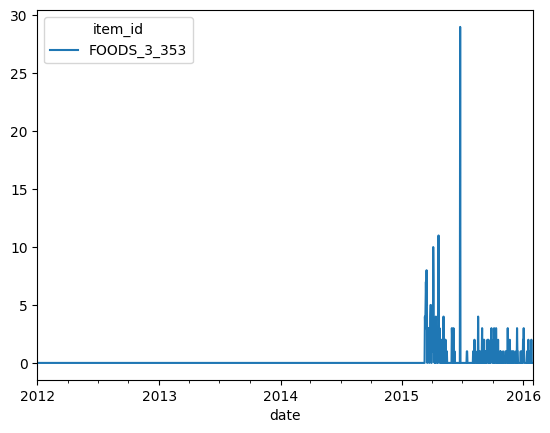

<Figure size 640x480 with 0 Axes>

In [20]:
plot_item(df_train_val, store_id="TX_2", item_id="FOODS_3_353")

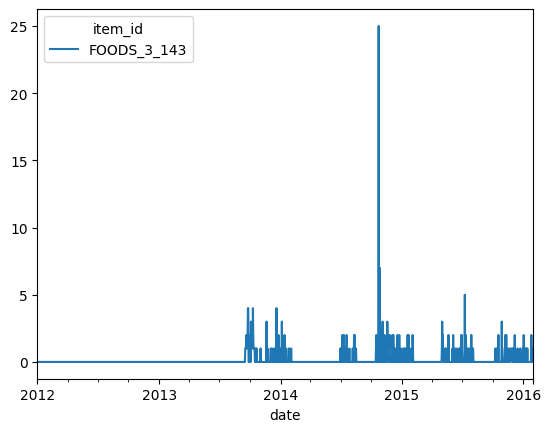

<Figure size 640x480 with 0 Axes>

In [21]:
plot_item(df_train_val, store_id="TX_1", item_id="FOODS_3_143")

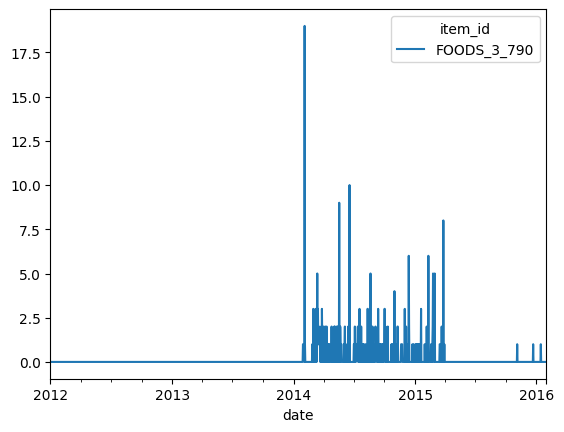

<Figure size 640x480 with 0 Axes>

In [22]:
plot_item(df_train_val, store_id="CA_3", item_id="FOODS_3_790")
	

In [27]:
def corr_stats(series_corr: pd.Series) -> pd.Series:
    store_id = series_corr.name[0]
    similarity_val = series_corr[[store_id]].max().round(4)
    similar_store_item = series_corr[[store_id]].idxmax()
    return pd.Series({"store_id":similar_store_item[0], "similar_item": similar_store_item[1], "similarity_val": similarity_val})


def plot_corr_items(df: pd.DataFrame, store_id: str, item_id_lst: list[str], **plt_args):
    (
        pd.pivot_table(
            data=df.loc[pd.IndexSlice[:, store_id,item_id_lst,:], :].reset_index(),
            index="date",
            columns="item_id",
            values="sales"
        )
        .plot(subplots=plt_args.get("subplots", False), alpha=plt_args.get("alpha", 0.7)))
    plt.show()

In [24]:
# Compute cosine similarity
series_corr = cosine_similarity(sparse_df)
series_corr -= np.identity(n=series_corr.shape[0])
corr_df = pd.DataFrame(series_corr, index=sparse_df.index, columns=sparse_df.index).round(4)  # .agg([min, max], axis=1).sort_values(by="max", ascending=False).head(10)
# corr_func = partial(corr_stats, idxes=corr_df.index)
complementary_items_df = corr_df.apply(corr_stats, axis=1).sort_values(by="similarity_val", ascending=False)

In [25]:
corr_df.apply(corr_stats, axis=1).sort_values(by="similarity_val", ascending=False).head(10)

store_id similar_item  similarity_val
state_id store_id item_id                                          
TX       TX_1     FOODS_3_033       TX         TX_1          0.6212
                  FOODS_3_471       TX         TX_1          0.6212
CA       CA_4     FOODS_3_038       CA         CA_4          0.5172
                  FOODS_3_429       CA         CA_4          0.5172
         CA_2     FOODS_3_613       CA         CA_2          0.5159
                  FOODS_3_251       CA         CA_2          0.5159
         CA_1     FOODS_3_260       CA         CA_4          0.5141
         CA_4     FOODS_3_200       CA         CA_4          0.4974
         CA_2     FOODS_3_743       CA         CA_2          0.4961
WI       WI_2     FOODS_3_417       WI         WI_2          0.4932

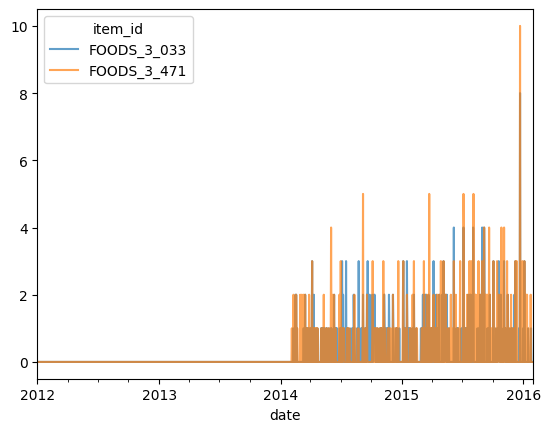

In [28]:
plot_corr_items(df=df_train_val, store_id="TX_1", item_id_lst=["FOODS_3_033", "FOODS_3_471"])

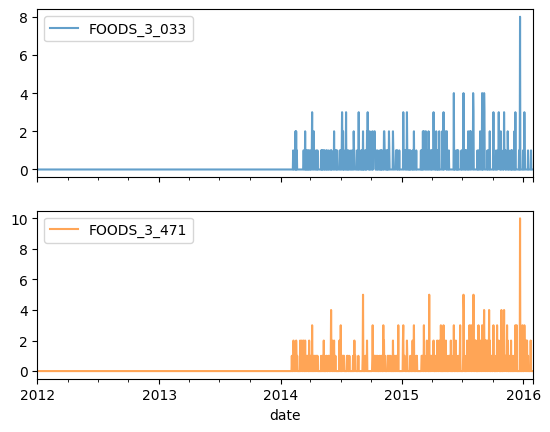

In [29]:
plot_corr_items(df=df_train_val, store_id="TX_1", item_id_lst=["FOODS_3_033", "FOODS_3_471"], subplots=True)

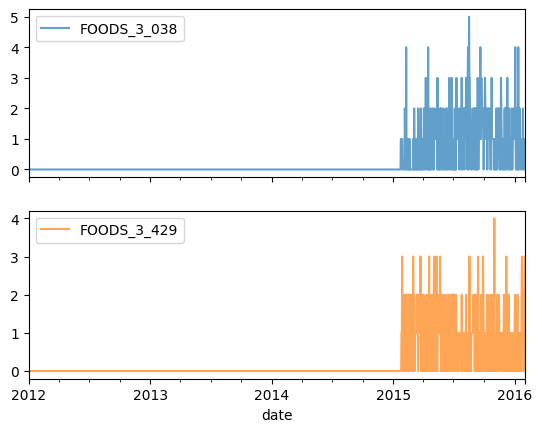

In [30]:
plot_corr_items(df=df_train_val, store_id="CA_4", item_id_lst=["FOODS_3_038", "FOODS_3_429"], subplots=True)

In [31]:
monthly_mean_sales = (
    df_train_val
    .reset_index(level="date")
    .groupby(["store_id", "item_id", pd.Grouper(key="date", freq="ME")])
    .mean()
)

monthly_mean_sales

sales
store_id item_id     date                
CA_1     FOODS_3_003 2012-01-31  0.000000
                     2012-02-29  0.000000
                     2012-03-31  0.000000
                     2012-04-30  0.000000
                     2012-05-31  0.000000
...                                   ...
WI_3     FOODS_3_815 2015-09-30  0.200000
                     2015-10-31  0.193548
                     2015-11-30  0.133333
                     2015-12-31  0.225806
                     2016-01-31  0.129032

[30821 rows x 1 columns]

In [32]:
def monthly_changes(monthly_diff_series: pd.Series, n_splits: int=3):
    splits = np.array_split(monthly_diff_series, n_splits)  # split into n sub-arrays
    changes_dict = {}
    changes_dict[f'pos_changes_total'] = (monthly_diff_series > 0).sum().item()
    changes_dict[f'neg_changes_total'] = (monthly_diff_series < 0).sum().item()
    for i, split in enumerate(splits):
        pos_changes = (split > 0).sum().item()
        changes_dict[f'pos_changes_{i}'] = pos_changes
        neg_changes = (split < 0).sum().item()
        changes_dict[f'neg_changes_{i}'] = neg_changes
    return pd.Series(changes_dict)

In [33]:
monthly_mean_sales.groupby(["store_id", "item_id"]).transform(lambda s: s.diff())

sales
store_id item_id     date                
CA_1     FOODS_3_003 2012-01-31       NaN
                     2012-02-29  0.000000
                     2012-03-31  0.000000
                     2012-04-30  0.000000
                     2012-05-31  0.000000
...                                   ...
WI_3     FOODS_3_815 2015-09-30  0.006452
                     2015-10-31 -0.006452
                     2015-11-30 -0.060215
                     2015-12-31  0.092473
                     2016-01-31 -0.096774

[30821 rows x 1 columns]

In [34]:
monthly_diff_sales = monthly_mean_sales.groupby(["store_id", "item_id"]).transform(lambda s: s.diff())

In [35]:
def apply_sign_pct_change(s: pd.Series) -> float:
    max_change = s[['pos_changes_total', 'neg_changes_total']].max()
    min_change = s[['pos_changes_total', 'neg_changes_total']].min()
    return (max_change - min_change) / min_change

In [36]:
monthly_diff_stats = monthly_diff_sales.groupby(["store_id", "item_id"]).apply(monthly_changes)
monthly_diff_stats['sign_pct_change'] = monthly_diff_stats.apply(apply_sign_pct_change, axis=1)

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [37]:
monthly_diff_stats.sort_values(by="sign_pct_change", ascending=False).head(10)

,,pos_changes_total,neg_changes_total,pos_changes_0,neg_changes_0,pos_changes_1,neg_changes_1,pos_changes_2,neg_changes_2,sign_pct_change
store_id,item_id,,,,,,,,,
CA_1,FOODS_3_563,8,2,0,0,0,0,8,2,3.000000
CA_2,FOODS_3_366,10,3,0,0,0,0,10,3,2.333333
CA_1,FOODS_3_796,6,2,0,0,0,0,6,2,2.000000
WI_3,FOODS_3_602,3,9,0,0,0,0,3,9,2.000000
TX_3,FOODS_3_545,5,2,0,0,0,0,5,2,1.500000
CA_2,FOODS_3_613,7,3,0,0,0,0,7,3,1.333333
CA_4,FOODS_3_038,9,4,0,0,0,0,9,4,1.250000
CA_2,FOODS_3_178,11,5,0,0,0,0,11,5,1.200000
TX_1,FOODS_3_235,9,19,3,3,2,8,4,8,1.111111


In [38]:
monthly_diff_stats.query("pos_changes_total < neg_changes_total").sort_values(by="sign_pct_change", ascending=False).head(10)

pos_changes_total  neg_changes_total  pos_changes_0  \
store_id item_id                                                            
WI_3     FOODS_3_602                  3                  9              0   
TX_1     FOODS_3_235                  9                 19              3   
CA_2     FOODS_3_549                  5                 10              0   
CA_4     FOODS_3_391                  7                 14              3   
WI_3     FOODS_3_609                  8                 14              1   
         FOODS_3_391                 11                 19              5   
CA_1     FOODS_3_164                  7                 12              0   
TX_3     FOODS_3_123                 12                 20              6   
WI_3     FOODS_3_143                  9                 15              1   
CA_4     FOODS_3_527                  8                 13              0   

                      neg_changes_0  pos_changes_1  neg_changes_1  \
store_id item_id                                                    
WI_3     FOODS_3_602              0              0              0   
TX_1     FOODS_3_235              3              2              8   
CA_2     FOODS_3_549              0              4              4   
CA_4     FOODS_3_391              7              1              1   
WI_3     FOODS_3_609              2              3              5   
         FOODS_3_391              7              4              2   
CA_1     FOODS_3_164              0              2              1   
TX_3     FOODS_3_123             10              5              6   
WI_3     FOODS_3_143              0              3              7   
CA_4     FOODS_3_527              0              2              4   

                      pos_changes_2  neg_changes_2  sign_pct_change  
store_id item_id                                                     
WI_3     FOODS_3_602              3              9         2.000000  
TX_1     FOODS_3_235              4              8         1.111111  
CA_2     FOODS_3_549              1              6         1.000000  
CA_4     FOODS_3_391              3              6         1.000000  
WI_3     FOODS_3_609              4              7         0.750000  
         FOODS_3_391              2             10         0.727273  
CA_1     FOODS_3_164              5             11         0.714286  
TX_3     FOODS_3_123              1              4         0.666667  
WI_3     FOODS_3_143              5              8         0.666667  
CA_4     FOODS_3_527              6              9         0.625000

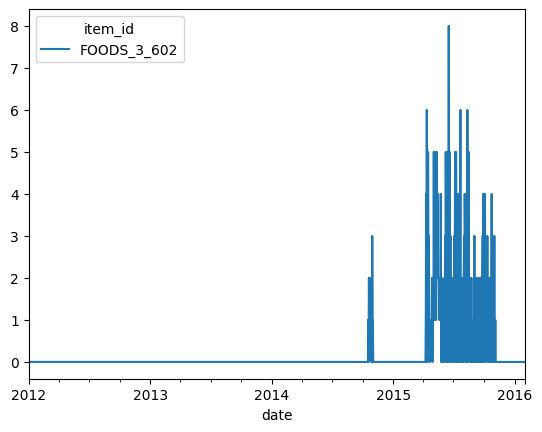

<Figure size 640x480 with 0 Axes>

In [39]:
plot_item(df=df_train_val, store_id="WI_3", item_id="FOODS_3_602")

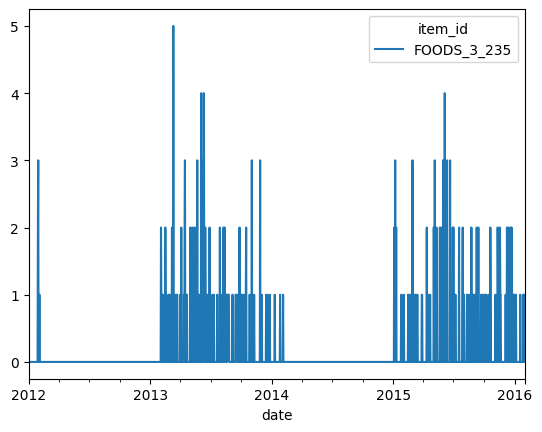

<Figure size 640x480 with 0 Axes>

In [40]:
plot_item(df=df_train_val, store_id="TX_1", item_id="FOODS_3_235")

In [41]:
df_train_val.index.get_level_values("item_id").nunique()

284

In [42]:
df_calendar = df_calendar.loc[df_calendar['date'].between(start_date, end_date)].copy()
df_calendar.head()

,date,wm_yr_wk,weekday,week_of_year,month,year,d,event_name,event,snap_CA,snap_TX,snap_WI
337,2012-01-01,11149,Sunday,52,1,2012,d_338,NewYear,1,1,1,0
338,2012-01-02,11149,Monday,1,1,2012,d_339,No Event,0,1,0,1
339,2012-01-03,11149,Tuesday,1,1,2012,d_340,No Event,0,1,1,1
340,2012-01-04,11149,Wednesday,1,1,2012,d_341,No Event,0,1,0,0
341,2012-01-05,11149,Thursday,1,1,2012,d_342,No Event,0,1,1,1


In [43]:
items = df_train_val.index.get_level_values("item_id").unique()

In [44]:
df_prices = df_prices.query("item_id in @items")

In [45]:
price_df = (
    pd.merge(df_prices, df_calendar.reset_index()[["wm_yr_wk", "date"]], on="wm_yr_wk")
    .set_index(["store_id", "item_id", "date"])
    .drop(columns="wm_yr_wk")
    .sort_index()
)
price_df

sell_price
store_id item_id     date                  
CA_1     FOODS_3_001 2012-01-01         2.5
                     2012-01-02         2.5
                     2012-01-03         2.5
                     2012-01-04         2.5
                     2012-01-05         2.5
...                                     ...
WI_3     FOODS_3_827 2016-01-27         1.0
                     2016-01-28         1.0
                     2016-01-29         1.0
                     2016-01-30         1.0
                     2016-01-31         1.0

[3037160 rows x 1 columns]

In [46]:
df_cal = (
    pd.wide_to_long(
        df_calendar.drop(columns=["d"]), 
        stubnames='snap_',
        i=["date"],
        j='state_id',
        suffix="\\D+"
    )
    .reorder_levels(order=["state_id", "date"])  # reorder index level
    .rename(columns={"snap_": "snap"}))
df_cal

event event_name  month  week_of_year    weekday  \
state_id date                                                           
CA       2012-01-01      1    NewYear      1            52     Sunday   
         2012-01-02      0   No Event      1             1     Monday   
         2012-01-03      0   No Event      1             1    Tuesday   
         2012-01-04      0   No Event      1             1  Wednesday   
         2012-01-05      0   No Event      1             1   Thursday   
...                    ...        ...    ...           ...        ...   
WI       2016-01-27      0   No Event      1             4  Wednesday   
         2016-01-28      0   No Event      1             4   Thursday   
         2016-01-29      0   No Event      1             4     Friday   
         2016-01-30      0   No Event      1             4   Saturday   
         2016-01-31      0   No Event      1             4     Sunday   

                     wm_yr_wk  year  snap  
state_id date                              
CA       2012-01-01     11149  2012     1  
         2012-01-02     11149  2012     1  
         2012-01-03     11149  2012     1  
         2012-01-04     11149  2012     1  
         2012-01-05     11149  2012     1  
...                       ...   ...   ...  
WI       2016-01-27     11552  2016     0  
         2016-01-28     11552  2016     0  
         2016-01-29     11552  2016     0  
         2016-01-30     11601  2016     0  
         2016-01-31     11601  2016     0  

[4476 rows x 8 columns]

In [47]:
X_price = (
    df_train_val
    .merge(price_df, on=["store_id", "item_id", "date"], how="left")
    .drop(columns="sales")
    .fillna(value=0.0)
    .set_index(df_train_val.index)
)

In [48]:
X_price.head()

sell_price
state_id store_id item_id     date                  
CA       CA_1     FOODS_3_003 2012-01-01         0.0
                              2012-01-02         0.0
                              2012-01-03         0.0
                              2012-01-04         0.0
                              2012-01-05         0.0

In [49]:
X_price

sell_price
state_id store_id item_id     date                  
CA       CA_1     FOODS_3_003 2012-01-01        0.00
                              2012-01-02        0.00
                              2012-01-03        0.00
                              2012-01-04        0.00
                              2012-01-05        0.00
...                                              ...
WI       WI_3     FOODS_3_815 2016-01-27        2.48
                              2016-01-28        2.48
                              2016-01-29        2.48
                              2016-01-30        2.48
                              2016-01-31        2.48

[938468 rows x 1 columns]

In [50]:
cols = ["weekday", "month", "year", "event_name", "sell_price"]
X = (
    X_price
    .merge(df_cal, on=["state_id", "date"])
    .set_index(X_price.index)
)
X = X[cols]
X

weekday  month  year event_name  \
state_id store_id item_id     date                                            
CA       CA_1     FOODS_3_003 2012-01-01     Sunday      1  2012    NewYear   
                              2012-01-02     Monday      1  2012   No Event   
                              2012-01-03    Tuesday      1  2012   No Event   
                              2012-01-04  Wednesday      1  2012   No Event   
                              2012-01-05   Thursday      1  2012   No Event   
...                                             ...    ...   ...        ...   
WI       WI_3     FOODS_3_815 2016-01-27  Wednesday      1  2016   No Event   
                              2016-01-28   Thursday      1  2016   No Event   
                              2016-01-29     Friday      1  2016   No Event   
                              2016-01-30   Saturday      1  2016   No Event   
                              2016-01-31     Sunday      1  2016   No Event   

                                          sell_price  
state_id store_id item_id     date                    
CA       CA_1     FOODS_3_003 2012-01-01        0.00  
                              2012-01-02        0.00  
                              2012-01-03        0.00  
                              2012-01-04        0.00  
                              2012-01-05        0.00  
...                                              ...  
WI       WI_3     FOODS_3_815 2016-01-27        2.48  
                              2016-01-28        2.48  
                              2016-01-29        2.48  
                              2016-01-30        2.48  
                              2016-01-31        2.48  

[938468 rows x 5 columns]

In [51]:
y = df_train_val[['sales']]

In [52]:
y

sales
state_id store_id item_id     date             
CA       CA_1     FOODS_3_003 2012-01-01      0
                              2012-01-02      0
                              2012-01-03      0
                              2012-01-04      0
                              2012-01-05      0
...                                         ...
WI       WI_3     FOODS_3_815 2016-01-27      0
                              2016-01-28      0
                              2016-01-29      0
                              2016-01-30      0
                              2016-01-31      0

[938468 rows x 1 columns]

In [56]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_series, plot_windows

from sktime.transformations.compose import Id, FeatureUnion, TransformerPipeline, ColumnEnsembleTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import OneHotEncoder

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sktime.forecasting.compose import RecursiveTabularRegressionForecaster, ForecastingPipeline, make_reduction
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from typing import Optional

In [54]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError
)
from sktime.forecasting.model_evaluation import evaluate

In [57]:
class OHEwithBaseline(OneHotEncoder):

    def __init__(self, baseline_category: str, drop_first: bool=False):
        self.baseline_category = baseline_category
        self.drop_first = drop_first
        self.ohe = OneHotEncoder(drop='first' if self.drop_first else None, sparse_output=False)

    def fit(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None):
        self.ohe.fit(X)
        categories_ = self.ohe.categories_[0].tolist()
        categories_.remove(self.baseline_category)
        categories_.insert(0,self.baseline_category)
        self.ohe.categories_[0] = np.array(categories_)
        return self

    def transform(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = self.ohe.transform(X)
        return X

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transform = self.ohe.inverse_transform(X)
        return X_transform

    def get_feature_names_out(self, *args, **params):
        return self.ohe.get_feature_names_out()

In [61]:
X_train.shape, X_test.shape

((918969, 5), (19499, 5))

In [63]:
X_train.tail()

weekday  month  year event_name  \
state_id store_id item_id     date                                            
WI       WI_3     FOODS_3_815 2015-12-27     Sunday     12  2015   No Event   
                              2015-12-28     Monday     12  2015   No Event   
                              2015-12-29    Tuesday     12  2015   No Event   
                              2015-12-30  Wednesday     12  2015   No Event   
                              2015-12-31   Thursday     12  2015   No Event   

                                          sell_price  
state_id store_id item_id     date                    
WI       WI_3     FOODS_3_815 2015-12-27        2.48  
                              2015-12-28        2.48  
                              2015-12-29        2.48  
                              2015-12-30        2.48  
                              2015-12-31        2.48

In [64]:
X_test.head()

weekday  month  year event_name  \
state_id store_id item_id     date                                           
CA       CA_1     FOODS_3_003 2016-01-01    Friday      1  2016    NewYear   
                              2016-01-02  Saturday      1  2016   No Event   
                              2016-01-03    Sunday      1  2016   No Event   
                              2016-01-04    Monday      1  2016   No Event   
                              2016-01-05   Tuesday      1  2016   No Event   

                                          sell_price  
state_id store_id item_id     date                    
CA       CA_1     FOODS_3_003 2016-01-01        3.98  
                              2016-01-02        3.98  
                              2016-01-03        3.98  
                              2016-01-04        3.98  
                              2016-01-05        3.98

In [58]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=31)

In [59]:
cv = ExpandingWindowSplitter(
    fh=np.arange(1, 31), initial_window=int(365 * 2), step_length=30
)

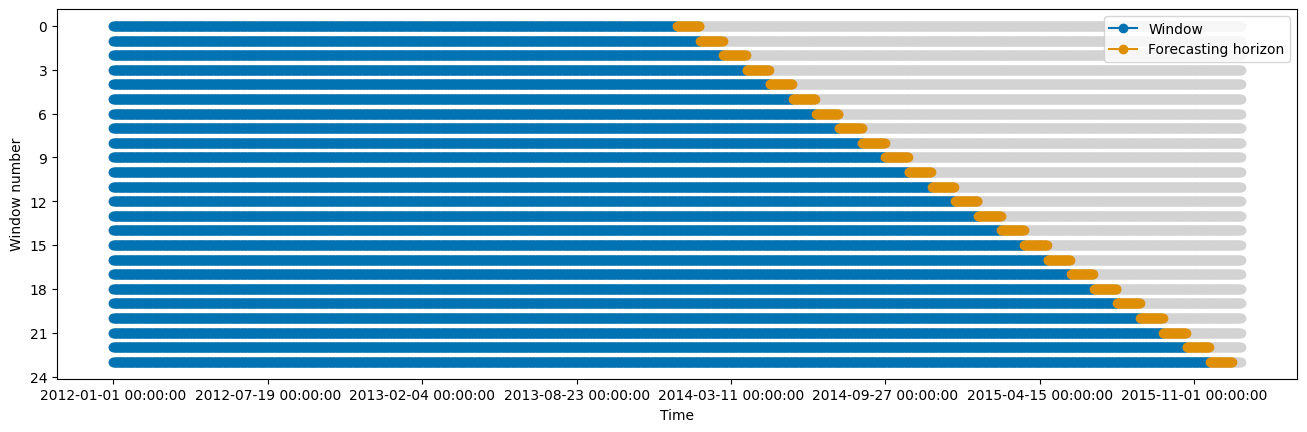

In [70]:
plot_windows(
    cv=cv,
    y=y_train.xs(("CA_1", "FOODS_3_003"), level=("store_id", "item_id")).reset_index(level="state_id", drop=True)
)
plt.show()

In [90]:
column_transformer = ColumnEnsembleTransformer(
    transformers=[
        (
            "ohe_week",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category="Monday", drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["weekday"]
        ),
        (
            "ohe_month",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category=1, drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["month"]
        ),
        # (
        #     "ohe_year",
        #     TabularToSeriesAdaptor(OHEwithBaseline(baseline_category=2012, drop_first=True).set_output(transform="pandas"), input_type="pandas"),
        #     ["year"]
        # ),
        (
            "ohe_event",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category='No Event', drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["event_name"]
        )
    ],
    remainder="passthrough",
    feature_names_out="original"
)

In [74]:
from sklearn.linear_model import LinearRegression

In [91]:
lr_forecaster = make_reduction(
        estimator=LinearRegression(),
        transformers=[WindowSummarizer(lag_feature={"lag": [1, 7, 30]})],   # add a lag feature
        strategy="recursive",
        pooling="global",
        window_length=None
)

lr_pipe = column_transformer ** lr_forecaster

# baseline- naive (weekly seasonal, last prediction)
nc_model = NaiveForecaster(sp=1)
# naive seasonal model with weekly seasonality 7
ns_model = NaiveForecaster(sp=7)

In [92]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

scoring = [mae, rmse]

In [84]:
lr_results = evaluate(lr_pipe, cv=cv, y=y_train, X=X_train, scoring=scoring, return_model=False)
lr_results

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sktime/utils/parallel.py:107: FitFailedWarning: 
                In evaluate, fitting of forecaster ForecastingPipeline failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=459170.
                The score will be set to nan.
                Failed forecaster with parameters: ForecastingPipeline(steps=[ColumnEnsembleTransformer(feature_names_out='original',
                                                     remainder='passthrough',
                                                     transformers=[('ohe_week',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           trans

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,16.126457,NaN,730,NaN
1,0.294911,0.420171,16.331428,84.461315,760,2014-01-29 00:00:00
2,0.322364,0.440255,15.110720,81.832642,790,2014-02-28 00:00:00
3,0.329753,0.452208,15.357371,81.645739,820,2014-03-30 00:00:00
4,0.334839,0.462853,15.337744,86.941025,850,2014-04-29 00:00:00
5,0.352274,0.477101,15.919943,86.585081,880,2014-05-29 00:00:00
6,0.348770,0.467569,16.739740,86.211847,910,2014-06-28 00:00:00
7,0.350692,0.473751,16.997711,85.973401,940,2014-07-28 00:00:00
8,0.350414,0.471303,16.895888,84.512696,970,2014-08-27 00:00:00
9,0.381319,0.531187,17.069292,87.027334,1000,2014-09-26 00:00:00


In [93]:
lr_pipe.fit(y=y_train, X=X_train, fh=np.arange(1, 32))

ForecastingPipeline(steps=[ColumnEnsembleTransformer(feature_names_out='original',
                                                     remainder='passthrough',
                                                     transformers=[('ohe_week',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           transformer=OHEwithBaseline(baseline_category='Monday', drop_first=True)),
                                                                    ['weekday']),
                                                                   ('ohe_month',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           transformer=OHEwithBaseline(basel...gory=1, drop_first=True)),
                                                                    ['month']),
                                                                   ('ohe_event',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           transformer=OHEwithBaseline(baseline_category='No Event', drop_first=True)),
                                                                    ['event_name'])]),
                           RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                                                pooling='global',
                                                                transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                    7,
                                                                                                                    30]})],
                                                                window_length=None)])

In [94]:
y_pred_lr = lr_pipe.predict(X=X_test)

In [95]:
y_pred_lr

sales
state_id store_id item_id     date                
CA       CA_1     FOODS_3_003 2016-01-01  0.236185
                              2016-01-02  0.320729
                              2016-01-03  0.339611
                              2016-01-04  0.294550
                              2016-01-05  0.278473
...                                            ...
WI       WI_3     FOODS_3_815 2016-01-27  0.299114
                              2016-01-28  0.294344
                              2016-01-29  0.461246
                              2016-01-30  0.375521
                              2016-01-31  0.384178

[19499 rows x 1 columns]

In [112]:
y_test.query("sales > 0")

sales
state_id store_id item_id     date             
CA       CA_1     FOODS_3_006 2016-01-01      1
                              2016-01-04      1
                              2016-01-05      1
                              2016-01-07      1
                              2016-01-09      1
...                                         ...
WI       WI_3     FOODS_3_806 2016-01-30      1
                              2016-01-31      2
                  FOODS_3_815 2016-01-02      1
                              2016-01-19      2
                              2016-01-24      1

[5272 rows x 1 columns]

In [85]:
nc_results = evaluate(nc_model, cv=cv, y=y_train, scoring=scoring, return_model=False)
nc_results

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,0.216534,0.364233,1.726030,2.814924,730,2013-12-30 00:00:00
1,0.245787,0.438806,1.609134,2.959411,760,2014-01-29 00:00:00
2,0.300901,0.474349,1.658306,2.858850,790,2014-02-28 00:00:00
3,0.347483,0.534298,1.643998,2.943306,820,2014-03-30 00:00:00
4,0.269422,0.477238,1.666138,2.861238,850,2014-04-29 00:00:00
5,0.295972,0.508668,1.782051,2.847689,880,2014-05-29 00:00:00
6,0.327292,0.523931,1.697353,2.966795,910,2014-06-28 00:00:00
7,0.309009,0.513045,1.725646,2.860559,940,2014-07-28 00:00:00
8,0.311394,0.518211,1.730751,2.960388,970,2014-08-27 00:00:00
9,0.346741,0.589921,1.755859,2.873068,1000,2014-09-26 00:00:00


In [113]:
nc_model.fit(y_train, fh=np.arange(1, 32))
nc_preds = nc_model.predict()

In [86]:
ns_results = evaluate(ns_model, cv=cv, y=y_train, scoring=scoring, return_model=False)
ns_results

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,0.195866,0.370393,1.627568,5.800056,730,2013-12-30 00:00:00
1,0.264706,0.475558,1.633696,5.774674,760,2014-01-29 00:00:00
2,0.294807,0.499208,1.757581,5.775493,790,2014-02-28 00:00:00
3,0.312189,0.542305,1.646649,5.885356,820,2014-03-30 00:00:00
4,0.294118,0.520371,1.674034,5.761344,850,2014-04-29 00:00:00
5,0.319237,0.553146,1.799370,5.723478,880,2014-05-29 00:00:00
6,0.323476,0.560884,1.784916,5.811810,910,2014-06-28 00:00:00
7,0.306836,0.538225,1.721376,5.764027,940,2014-07-28 00:00:00
8,0.315845,0.556681,1.742194,5.859814,970,2014-08-27 00:00:00
9,0.342819,0.611333,1.743536,5.745822,1000,2014-09-26 00:00:00


In [115]:
ns_model.fit(y_train, fh=np.arange(1, 32))
ns_preds = ns_model.predict()

In [127]:
def plot_preds(y_train, y_test, preds_dict, state_id, store_id, item_id, **kwargs_plot):
    y = pd.concat([y_train.loc[state_id, store_id, item_id], y_test.loc[state_id, store_id, item_id]], axis=0)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y, label="train", alpha=kwargs_plot.get("alpha", 0.7))
    for label, (preds, pred_color) in preds_dict.items():
        y_pred = preds.loc[state_id, store_id, item_id]
        ax.plot(y_pred, label=label, color=pred_color, alpha=kwargs_plot.get("alpha", 0.7))
    ax.set_title(f"{store_id} {item_id}")    
    ax.legend()
    fig.autofmt_xdate()
    plt.show()


def residual_plot(y_test, preds_dict, state_id, store_id, item_id, **kwargs_plot):
    fig, axes = plt.subplots(figsize=(6, 8), nrows=len(pred_dict), sharex=True,layout="tight")
    for i, (pred_name, (preds, _)) in enumerate(preds_dict.items()): 
        residuals = y_test.loc[state_id, store_id, item_id] - preds.loc[state_id, store_id, item_id]
        axes[i].plot(residuals, color="salmon")
        axes[i].set_title(f"Residual Plot {store_id} {item_id} ({pred_name})")
    fig.autofmt_xdate()
    fig.suptitle("Residual Plot")
    plt.show()
    

In [ ]:
pred_dict = {"LR": [y_pred_lr, "orange"], "Naive": [nc_preds, "blueviolet"], "Naive Seasonal": [ns_preds, "goldenrod"]}

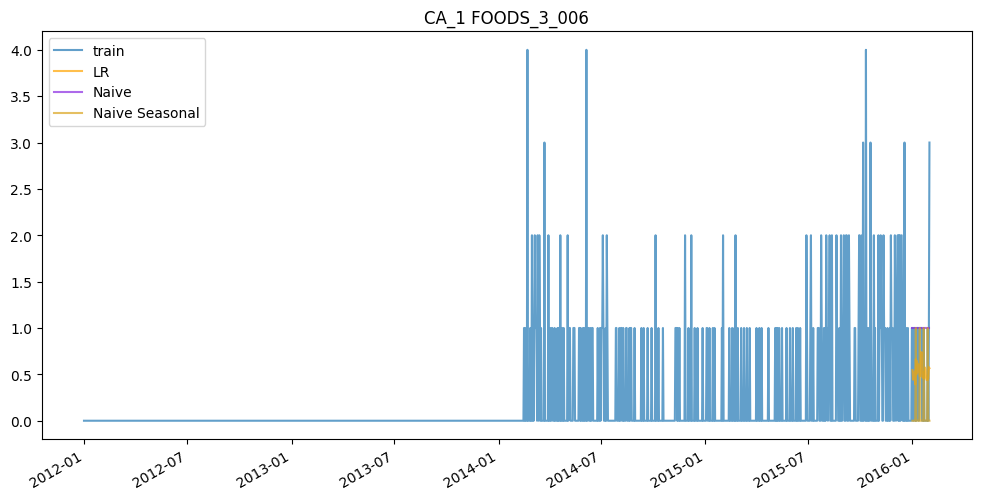

In [123]:
plot_preds(y_train, y_test, pred_dict, state_id="CA", store_id="CA_1", item_id="FOODS_3_006")

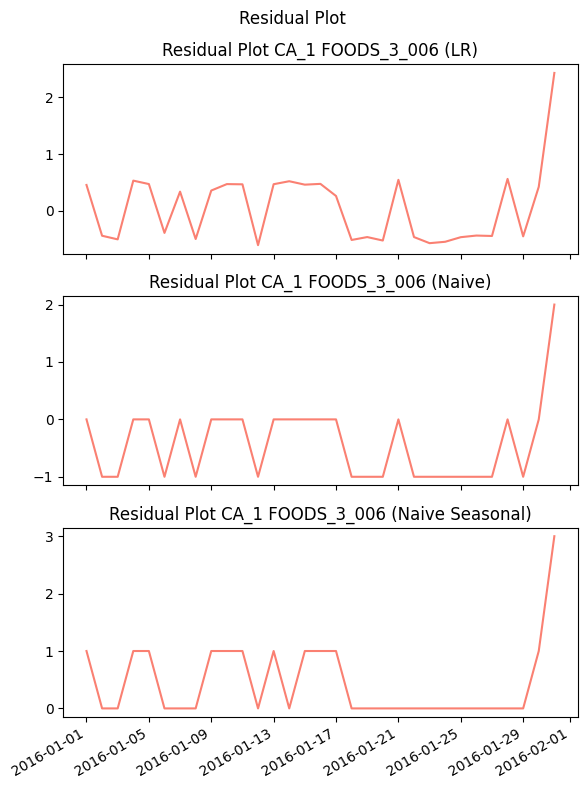

In [128]:
residual_plot(y_test, pred_dict, state_id="CA", store_id="CA_1", item_id="FOODS_3_006")